# Widespread Error Detection in Large Scale Continuous Integration Systems

---

- Stanislaw Swierc (stansw)
- James Lu (luchangj)
- Thomas Yi (thomasyi)

\* @meta.com

https://github.com/StanislawSwierc/CCIW2024-Widespread-Error-Detection

<img src="http://s21.q4cdn.com/399680738/files/design/2022/01/Meta_lockup_positive-primary_RGB-(1).jpg" style="float:right;">

# Disclaimer

> This presentation contains sample code with a basic pipeline for detecting widespread errors in the React open-source project.
>
>It does NOT contain any code, logs or data internal to Meta Platforms, Inc.


# Notes: Goal

> The goal of this presentation is to share enough ideas and sample code for you to go back from this conference, build a prototype and get a green light from your leadership to move forward! Then, you can extend it to meet the unique needs of your company.

# Motivation

> Improve developer productivity by quickly detecting and mitigating the impact of widespread errors.



# Motivation: Widespread Errors

Widespread errors are commonly infrastructural errors that falsely block developers from integrating their code changes into the mainline branch.

Why is this bad?
- **Productivity** - Developers waste time trying to fix code, when it is not at fault.
- **Trust** - Erodes confidence in CI System's ability to produce validation signals.
- **Efficiency** - Need to re-run failing validation, thus, wasting machine resources.

# Motivation: Impact vs. Frequency

We can organize errors by number of affected people and how common they are:



<img src="media/impact_vs_frequency.png" style="width:550px;"/>

Challenges
- Rare, widespread errors may appear like a group of concentrated errors.
- Capturing signatures of rare, widespread errors is only good for retroactive analysis, but not for detection.


In [45]:
import os
import re2
import requests
import jsonlines
import numpy as np
import pandas as pd

from datetime import datetime
#from tqdm.notebook import trange, tqdm
from tqdm import tqdm

In [388]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [188]:
import plotly.express as px
import plotly.io as pio
import plotly.figure_factory as ff
import plotly.graph_objects as go

pio.templates.default = "plotly_white"

default_layout = dict(
    width=1200,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    ),
    margin=dict(
        l=10,
        r=10,
        b=10,
        t=20,
    ),
)

# https://plotly.com/python/renderers/
# https://plotly.com/python/troubleshooting/#jupyter-classic-notebook-problems
CLASSIC = True
if CLASSIC:
    pio.renderers.default="svg"

# React Case Study

React uses CircleCI to validate pull requests and the health of the mainline branch.

- **Project** - validation configuration for the code repository
  - **Pipeline** - group of workflows
    - **Workflow** - graph of jobs
      - **Job** - set of steps executed sequentially
        - **Step/Action** - execution unit
          - **Logs** - standard output and summary
        
        


*https://circleci.com/docs/concepts*

# React Case Study: CircleCI API
CircleCI offers an API to fetch information about pipelines and other resources all the way to individual logs.

In [3]:
from pycircleci.api import Api

ORG = "facebook"
PROJECT = "react"
TOKEN = "{token}" 

client = Api(token=TOKEN)

In [37]:
%%script true

client.get_project_pipelines(...
client.get_pipeline_workflow(...
client.get_workflow_jobs(...
client.get_job_details_v1(...
client._session.get(action["output_url"])

In [5]:
from requests_ratelimiter import LimiterAdapter

def configure_rate_limiting(client):
    adapter = LimiterAdapter(per_second=5)
    client._session.mount('http://', adapter)
    client._session.mount('https://', adapter)

configure_rate_limiting(client)

In [6]:
# Monkey patch pycircleci.Api and add a new method.

def get_job_details_v1(self, username, project, job_number, vcs_type="github"):
    """Get job details using v1 api.

    This api offers additional details about steps.
    """
    slug = self.project_slug(username, project, vcs_type)
    endpoint = f"project/{slug}/{job_number}"
    resp = self._request("GET", endpoint, api_version="v1.1")
    return resp

Api.get_job_details_v1 = get_job_details_v1

In [7]:
def update_workflows(client, org, project, pipeline):
    """Set information about workflows."""
    if "workflows" not in pipeline:
        workflows = client.get_pipeline_workflow(pipeline["id"], paginate=True)
        pipeline["workflows"] = workflows

def update_jobs(client, org, project, pipeline):
    """Set information about jobs."""
    for workflow in [
        w
        for w in pipeline.get("workflows", [])
        if "jobs" not in w
    ]:
        jobs = client.get_workflow_jobs(workflow["id"], paginate=True)
        workflow["jobs"] = jobs

def update_job_details(client, org, project, pipeline, job_status=None):
    """Set detailed information about jobs."""
    for job in [
        j 
        for w in pipeline.get("workflows", [])
        for j in w.get("jobs", [])
        if "details" not in j 
            and "job_number" in j 
            and (job_status is None or j["status"] == job_status)
    ]:
        job_details = client.get_job_details(org, project, job["job_number"])
        job["details"] = job_details

def update_steps(client, org, project, pipeline, job_status=None, action_status=None):
    """Set very detailed information about jobs, steps and actions."""
    for job in tqdm([
        j
        for w in pipeline.get("workflows", [])
        for j in w.get("jobs", [])
        if "details_v1" not in j
            and "job_number" in j
            and (job_status is None or j["status"] == job_status)
    ], leave=False, desc="Jobs"):
        job_details = client.get_job_details_v1(org, project, job["job_number"])

        # Fetch output immediately because "output_url" has an access
        # token, which is valid only for 5 minutes. 
        for action in [
            a 
            for s in job_details["steps"]
            for a in s["actions"]
            if "output_url" in a 
                and "output" not in a
                and (action_status is None or a["status"] == action_status)
        ]:
            resp = client._session.get(action["output_url"])
            resp.raise_for_status()
            action["output"] = resp.json()

        job["details_v1"] = job_details

In [16]:
pipelines_path = 'pipelines.jsonl'

if os.path.exists(pipelines_path):
    with jsonlines.open(pipelines_path) as reader:
        pipelines = list(tqdm(reader)) 
else:
    pipelines = client.get_project_pipelines(org, project, paginate=True, limit=1000)

    np.random.seed(42)
    for pipeline in tqdm(pipelines, desc="Pipelines"):
        update_workflows(client, org, project, pipeline)   
        update_jobs(client, org, project, pipeline)
        if np.random.rand() < 0.99:
            update_steps(client, org, project, pipeline,
                job_status="failed", action_status="failed")
        else:
            update_steps(client, org, project, pipeline)

    with jsonlines.open(pipelines_path, mode='w') as writer:
        for p in pipelines:
            writer.write(p)

0it [00:00, ?it/s]

In [18]:
# https://stackoverflow.com/questions/14693701
ansi_escape_sequences_regex = re2.compile(
    r'\x1B(?:[@-Z\\-_]|\[[0-?]*[ -/]*[@-~])')

def remove_ansi_escape_sequences(text):
    return ansi_escape_sequences_regex.sub("", text)

In [67]:
actions = pd.DataFrame(
[
    { 
        "pipeline_id": p["id"],
        #"pipeline_number": p["number"],
        #"pipeline_vcs_branch": p["vcs"]["branch"],
        "pipeline_actor_login": p["trigger"]["actor"]["login"],
        "workflow_id": w["id"],
        "workflow_name": w["name"],
        "workflow_status": w["status"],
        "job_id": j["id"],
        #"job_number": j["job_number"],
        "job_name": j["name"],
        "job_status": j["status"],
        "job_link": f"https://app.circleci.com/pipelines/github/facebook/react/{p["number"]}/workflows/{w["id"]}/jobs/{j["job_number"]}/parallel-runs/{a["index"]}?filterBy=ALL",
        "action_name": a["name"],
        "action_fully_qualified_name": "/".join([w["name"], j["name"], a["name"]]),
        "action_index": a["index"],
        "action_status": a["status"],
        "action_output_time": datetime.fromisoformat(o["time"]),
        "action_output_message": remove_ansi_escape_sequences(o["message"]),
        "action_output_type": o["type"],        
    }   
    for p in tqdm(pipelines)
    for w in p.get("workflows", [])
    for j in w.get("jobs", [])
    for s in j.get("details_v1", {}).get("steps", [])
    for a in s.get("actions", [])
    for o in a.get("output", [])
]).assign(
    action_output_date = lambda df: df["action_output_time"].dt.round("1d")
)

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:52<00:00, 94.67it/s]


In [30]:
!du -h pipelines.jsonl

4.4G	pipelines.jsonl


*https://circleci.com/docs/api/v2/index.html*  
*https://circleci.com/docs/managing-api-tokens*

# # React Case Study: Actions Fact Table


In [29]:
actions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 341630 entries, 0 to 341629
Data columns (total 17 columns):
 #   Column                       Non-Null Count   Dtype              
---  ------                       --------------   -----              
 0   pipeline_id                  341630 non-null  object             
 1   pipeline_actor_login         341630 non-null  object             
 2   workflow_id                  341630 non-null  object             
 3   workflow_name                341630 non-null  object             
 4   workflow_status              341630 non-null  object             
 5   job_id                       341630 non-null  object             
 6   job_name                     341630 non-null  object             
 7   job_status                   341630 non-null  object             
 8   job_link                     341630 non-null  object             
 9   action_name                  341630 non-null  object             
 10  action_fully_qualified_name  341

# Pipeline Design

<img src="media/component_diagram_1.png" style="height:700px;"/>

# Extraction

# Extraction

Given a log file for a failed build or tests, extracts the snippet describing the error.


1. **Federated solution** - allow teams to provide custom rules for extracting relevant error snippets.
2. **General solution** - find lines which appear only in logs of failed actions.


# Extraction: Example

<!--![](media/error_snippet.png)-->

<img src="media/error_snippet.png" style="height:700px;"/>

https://app.circleci.com/pipelines/github/facebook/react/50369/workflows/a074d639-5829-4708-b5c1-3bb69610b578/jobs/780483/parallel-runs/10?filterBy=ALL

# Extraction: Sample Code

In [142]:
import cachetools
from collections import defaultdict

token_regex = re2.compile(r"\b[[:alpha:]_][[:alpha:][:digit:]_-]+")

def parse_line(text):
    return ";".join(token_regex.findall(line))

In [183]:
def assign_action_output_failure(df, cache_size=2048):
    result = []
    action_cache = defaultdict(lambda: cachetools.LRUCache(cache_size))
    for i, row in tqdm(df.iterrows(), total=len(df)):
        failure_lines = []
        success_cache = action_cache[row["action_fully_qualified_name"]]
        for line in row["action_output_message"].splitlines():
            template = parse_line(line)
            
            if row["action_status"] == "success":
                success_cache[template] = True
            elif not template or template not in success_cache:
                failure_lines.append(line)
                
        result.append("\n".join(failure_lines))
    return result

In [ ]:
actions =  actions.assign(
    action_output_failure = assign_action_output_failure
)

In [129]:
# Find examples of jobs with passing and failing tests and short logs.
(
  actions
  .query("action_status == 'failed'")
  .query("action_output_type == 'out'")
  .query("action_output_message.str.contains('PASS')")
  .query("action_output_failure.str.contains('FAIL')")
  .assign(action_output_message_length = lambda df: df["action_output_message"].str.len())
  .sort_values("action_output_message_length")
  .head(5)
  .loc[:, "job_link"]
  .apply(print)
)
None

https://app.circleci.com/pipelines/github/facebook/react/50369/workflows/a074d639-5829-4708-b5c1-3bb69610b578/jobs/780483/parallel-runs/10?filterBy=ALL
https://app.circleci.com/pipelines/github/facebook/react/50370/workflows/1d411977-e2da-4c0b-aaf1-8afa9f8315ce/jobs/780523/parallel-runs/10?filterBy=ALL
https://app.circleci.com/pipelines/github/facebook/react/50372/workflows/9e5ff90c-4a57-4368-b0d1-1a7199651605/jobs/780583/parallel-runs/10?filterBy=ALL
https://app.circleci.com/pipelines/github/facebook/react/50813/workflows/69f540c5-c70a-4742-b3de-65ffa3b1c616/jobs/793195/parallel-runs/3?filterBy=ALL
https://app.circleci.com/pipelines/github/facebook/react/52545/workflows/25ac236a-e080-4f25-9c64-1fb16534549d/jobs/844606/parallel-runs/2?filterBy=ALL


# Extraction: Results

In [432]:
line_num_ecdf_fig = (
    actions
    .query("action_status == 'failed'")
    .query("action_output_type == 'out'")
    .rename(columns={
        "action_output_message":"original",
        "action_output_failure":"reduced"
    })
    .melt(value_vars=["original", "reduced"])
    .rename(columns={"variable":"version"})
    .assign(line_num = lambda df: df["value"].str.count("\n"))
    .pipe(
        px.ecdf,
        x="line_num",
        color="version"
    )
    .update_layout(
        **default_layout,
        title="Empirical Cumulative Distribution Plots of Line Numbers",
        xaxis_title="Number of Lines",
        xaxis_range=[0, 200],
        yaxis_title="Probability",
        yaxis_tickformat=",.0%"
    )
)

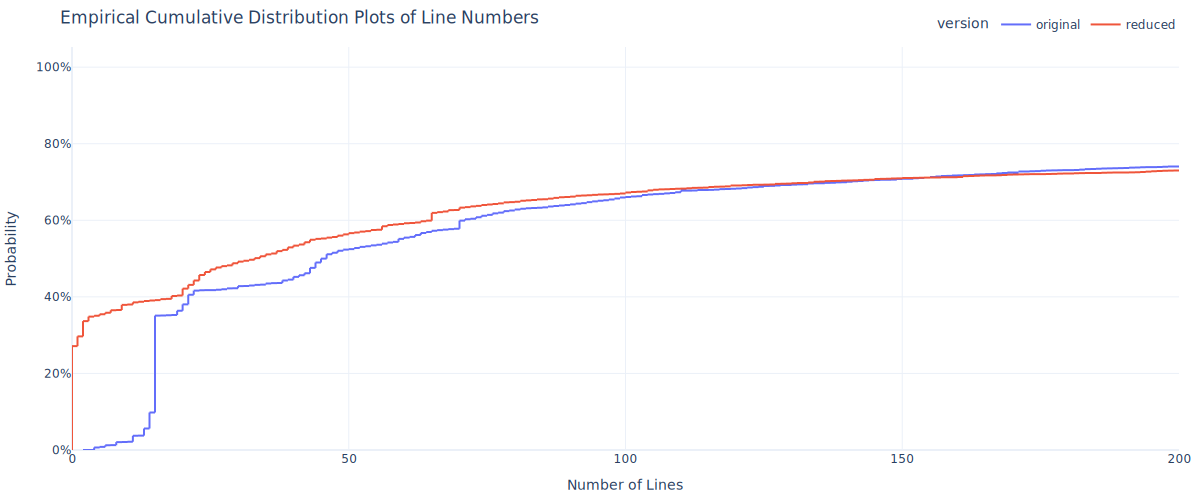

In [433]:
line_num_ecdf_fig.show()

# Extraction: Extensions

1. Use log parser and diff failures based on log templates  
  *Jiang, Z., Liu, J., Huang, J., Li, Y., Huo, Y., Gu, J., Chen, Z., Zhu, J. and Lyu, M.R., 2023. A Large-scale Benchmark for Log Parsing*


# Vectorization

# Vectorization

Convert raw text data into a numerical format that can be efficiently processed.


1. Bag-of-word model with open-vocabulary
2. Minhash (e.g. with 256 x 16-bit we get a constant 0.5 kB per error)

<center>
<img src="media/jaccard.png" style="height:250px;"/>
</center>

*Leskovec J, Rajaraman A, Ullman JD. "Chapter 3: Finding Similar Items" Mining of massive data sets. Cambridge university press; 2020 Jan 9.*

# Vectorization: Normalization
Reduce the size of the vocabulary by removing common hashes and common metadata.

In [236]:
normalize_rules = [
    ("{GUID}", re2.compile(r'[0-9a-f]{8}-[0-9a-f]{4}-[0-9a-f]{4}-[0-9a-f]{4}-[0-9a-f]{12}')),
]

def normalize(text):
    for repl, regex in normalize_rules:
        text = regex.sub(repl, text)
    return text

# Vectorization: Tokenization
Extract meaningful tokens.

In [136]:
token_regex = re2.compile(r"\b[[:alpha:]_][[:alpha:][:digit:]_-]+")

def tokenize(text):
    normalized_text = normalize(text)
    return token_regex.findall(normalized_text)

# Vectorization: Minhash
Convert set of tokens to Minhash sketches.

In [182]:
from datasketch import MinHash

NUM_PERM = 256

def vectorize(tokens):
    m = MinHash(num_perm=NUM_PERM)
    for token in set(tokens):
        m.update(token.encode('utf8'))
    return m.hashvalues

# Vectorization: Results
Minhash representation is more compact and allows for fast nearest-neighbors search.

Total size of original text data:

In [238]:
print("{:.3f} GB".format(actions["action_output_message"].str.len().sum() / 2 ** 30))

1.978 GB


Total size of minhash sketches:

In [234]:
print("{:.3f} GB".format(actions.shape[0] * np.uint16(0).nbytes * NUM_PERM / 2 ** 30))

0.163 GB


# Vectorization: Extensions
1. **Process documents in parallel.** Vectorization is embarrassingly parallelizable.
2. **Use Weighted Minhash**. Minhash with Inverse Document Frequency (IDF) weights can automatically ignore common terms such as "failed".  
  *Chum, O., Philbin, J. and Zisserman, A., 2008, September. Near duplicate image detection: Min-hash and TF-IDF weighting.*
3. **Use Neural Network Vector Embeddings (future).** Embeddings are a good alternative to Minhash sketches and they can capture semantics of logs.  
  *Meng, W., Liu, Y., Huang, Y., Zhang, S., Zaiter, F., Chen, B. and Pei, D., 2020, August. A semantic-aware representation framework for online log analysis.*

In [270]:
actions = actions.assign(
    action_output_sketch=lambda df: [
        vectorize(tokenize(x))
        for x in tqdm(df["action_output_failure"])])

100%|█████████████████████████████████████████████████████████████████████████| 341630/341630 [13:45<00:00, 414.04it/s]


# Clustering

# Clustering
Given vector representation of the error, find a **near-duplicate cluster** or create a new cluster. 

- Near-duplicate search is performed on a vector database.
- For Minhash the database should support *Generalized Hamming Distance*.
- LSH Forest is an efficient data structure and offers time complexity of $O(n log(n))$.

*Bawa, M., Condie, T. and Ganesan, P., 2005, May. LSH forest: self-tuning indexes for similarity search.*


In [273]:
from datasketch import MinHashLSHForest
from sortedcontainers import SortedDict

def jaccard_distance(a, b):
    return 1 - float(np.count_nonzero(a == b)) / len(a)
    
class DefaultSortedDict(SortedDict):
    def __init__(self, default_factory, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.default_factory = default_factory

    def __missing__(self, key):
        self[key] = value = self.default_factory()
        return value

class MinHashLSHOnlineForest(MinHashLSHForest):
    def __init__(self, num_perm, num_trees):
        super().__init__(num_perm, num_trees)
        hashtables = [DefaultSortedDict(list) for _ in range(num_trees)]

    def index(self):
        for i, hashtable in enumerate(self.hashtables):
            self.sorted_hashtables[i] = list(hashtable.keys())
            
    def add(self, key, minhash):
        super().add(key, minhash)
        self.index()

# Clustering: Sample Code

In [274]:
MAX_DISTANCE = 0.25

def assign_action_output_cluster_info(df):
    cluster_info = []
    forest = MinHashLSHOnlineForest(num_perm=NUM_PERM, num_trees=16)
    for index, sketch in tqdm(df["action_output_sketch"].items(), total=len(df)):        
        neighbors = forest.query(MinHash(hashvalues=sketch), 10)
        
        if neighbors:
            distances = [jaccard_distance(sketch, x) for x in df.loc[neighbors, "action_output_sketch"]]
            nearest_i = np.argmin(distances)
            nearest_index, nearest_dist = (neighbors[nearest_i], distances[nearest_i])
        else:
            nearest_index, nearest_dist = (0, 1.0)

        if nearest_dist < MAX_DISTANCE:
            cluster_info.append((nearest_index, nearest_dist)) # Use nearest index as cluster
        else:
            cluster_info.append((index, 0.0)) # Create new cluster with current index
            forest.add(index, MinHash(hashvalues=sketch)) 
            
    return cluster_info

In [275]:
actions = (
    actions
    .assign(
        action_output_cluster_info=assign_action_output_cluster_info
    )
    .assign(
        action_output_cluster_id = lambda df:[
            i for i, _ in df["action_output_cluster_info"]
        ],
        action_output_cluster_dist = lambda df:[
            d for _, d in df["action_output_cluster_info"]
        ]
    )
    .drop(columns="action_output_cluster_info")
)

100%|█████████████████████████████████████████████████████████████████████████| 341630/341630 [15:52<00:00, 358.79it/s]


# Clustering: Resulsts

In [427]:
cluster_size_ecdf_fig = (
    actions
    .query("action_status == 'failed'")
    .query("action_output_type == 'out'")
    .groupby("action_output_cluster_id")
    .agg(count=("action_index", "count"))
    .reset_index()
    .pipe(
        px.ecdf,
        x="count",
    )
    .update_layout(
        **default_layout,
        title="Empirical Cumulative Distribution Plot of Cluster Size",
        xaxis_title="Cluster Size",
        xaxis_range=[0, 100],
        yaxis_title="Probability",
        yaxis_tickformat=",.0%",
        yaxis_range=[0.9, 1],
    )
    .update_layout(
        margin=dict(
            l=10,
            r=10,
            b=10,
            t=40,
        ),
    )
)

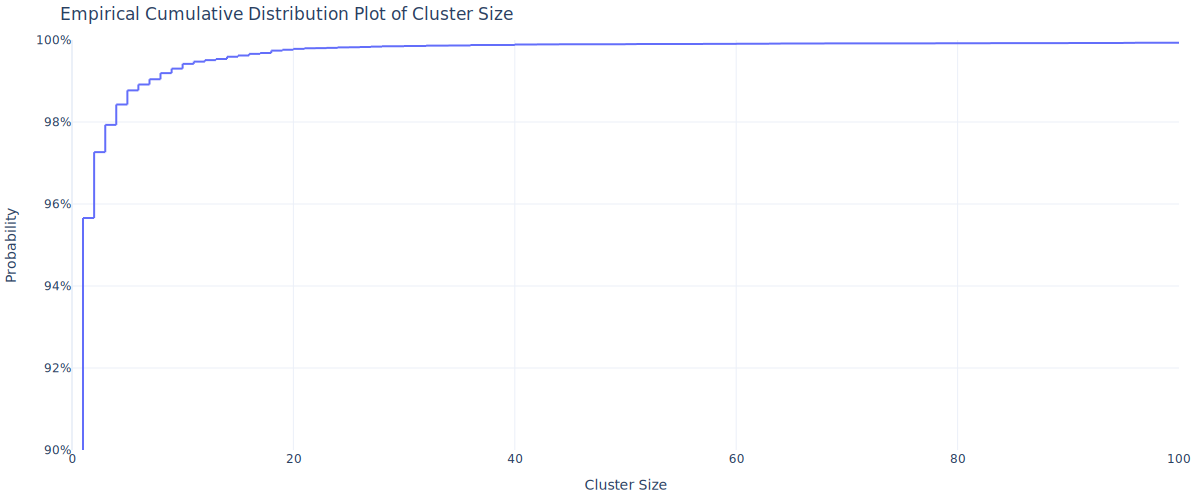

In [429]:
cluster_size_ecdf_fig.show()

# Clustering: Extensions
1. **Partition clusters by creation time.**
  Clustering is an append only process. This opens up the opportunity to partition clusters by creation time to optimize database access.
2. **Detect and fix duplicate clusters.**
  If many similar errors get processed at the same time, they may end up creating many clusters. There is a need of a background job which will detect and fix duplicate clusters. 
3. **Use different distance thresholds for different classes of errors.** Different frameworks may produce different logs and they may benefit from using criteria for near-duplicate failure.
4. **Use Least Recently Used (LRU) policy to manage cluster lifetime**. Most clusters represent unique errors and can be safely deleted after just a few days.

# Statistics

# Statistics: Top clusters by number of failed actions

In [362]:
cluster_daily_stats = (
    actions
    .query("action_status == 'failed'")
    .query("action_output_type == 'out'")
    .groupby(["action_output_date", "action_output_cluster_id"])
    .agg(
        unique_users_num=("pipeline_actor_login", "nunique"),
        actions_num=("action_index", "count"),
    )
    .reset_index()
    .sort_values(["unique_users_num","actions_num"], ascending=False)
)

In [409]:
(
    cluster_daily_stats
    .groupby("action_output_cluster_id")
    .agg(
        days_num=("unique_users_num", "count"),
        actions_num=("actions_num", "sum"),
    )
    .reset_index()
    .sort_values(["days_num","actions_num"], ascending=False)
    .head(5)
)

,action_output_cluster_id,days_num,actions_num
18873,200347,7,8
35350,308696,5,229
20658,226264,4,8
35417,309408,4,7
35828,311102,3,11


In [344]:
top_clusters_by_number_of_actions_fig = (
    cluster_daily_stats
    .sort_values("actions_num", ascending=False)  
    .head(100)
    .assign(action_output_cluster_id = lambda df: df["action_output_cluster_id"].astype(str))
    .pipe(
        px.bar,
        x="action_output_date",
        y="actions_num",
    )
    .update_layout(
        **default_layout,
        title="Top cluster by number of failed actions",
        xaxis_title="Date",
        yaxis_title="Number of failed actions",
        showlegend=False,
    )
    .update_layout(
        margin=dict(
            l=10,
            r=10,
            b=10,
            t=40,
        ),
    )
)

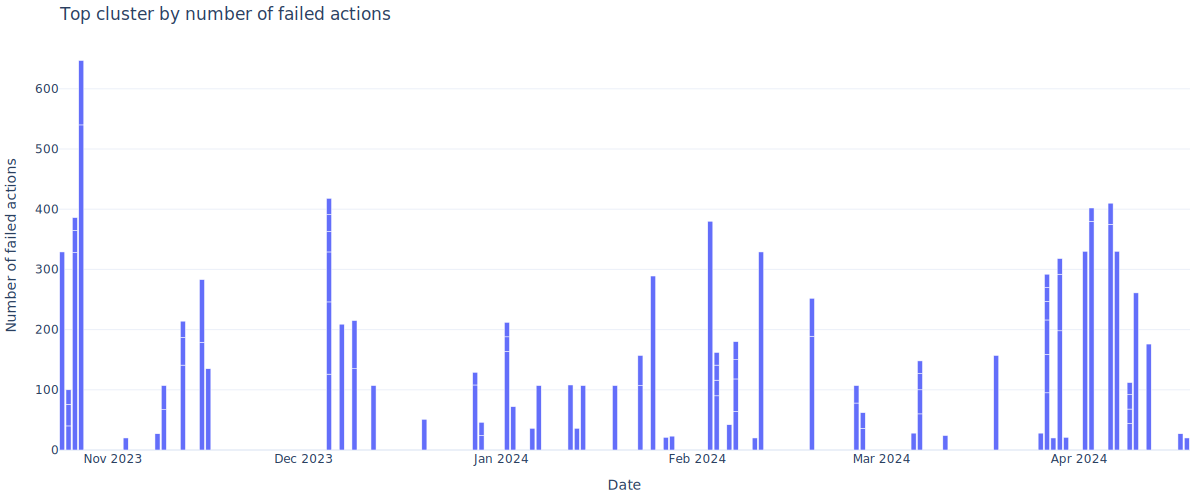

In [430]:
top_clusters_by_number_of_actions_fig.show()

# Statistics: Top clusters by number of failed actions

In [365]:
cluster_daily_stats.sort_values("actions_num", ascending=False).head()

,action_output_date,action_output_cluster_id,unique_users_num,actions_num
2048,2023-10-27 00:00:00+00:00,335630,2,540
32413,2024-04-03 00:00:00+00:00,156330,1,380
9925,2024-02-03 00:00:00+00:00,288279,1,380
35344,2024-04-06 00:00:00+00:00,131692,1,375
36228,2024-04-07 00:00:00+00:00,129316,1,330


In [367]:
print(actions.loc[335630, "action_output_failure"])


fatal: reference is not a tree: f5b4060fec2bd637a88bfafbcc16b87f0241656c


In [366]:
print(actions.loc[156330, "action_output_failure"])

$ jest --build -r=experimental --env=development --ci
● Unrecognized CLI Parameter:

  Unrecognized option "build". Did you mean "bail"?

  CLI Options Documentation:
  https://jestjs.io/docs/cli

error Command failed with exit code 1.
info Visit https://yarnpkg.com/en/docs/cli/run for documentation about this command.


# Statistics: Top clusters by number of affected users

In [360]:
top_clusters_by_unique_users_fig = (
    cluster_daily_stats
    .head(10)
    .assign(action_output_cluster_id = lambda df: df["action_output_cluster_id"].astype(str))
    .pipe(
        px.bar,
        x="action_output_date",
        y="unique_users_num",
        color="action_output_cluster_id"
    )
    .update_layout(
        **default_layout,
        title="Top cluster by number of affected users",
        xaxis_title="Date",
        yaxis_title="Number of failed actions",
    )
    .update_layout(
        margin=dict(
            l=10,
            r=10,
            b=10,
            t=40,
        ),
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=0.96,
            xanchor="right",
            x=1
        ),
    )
)

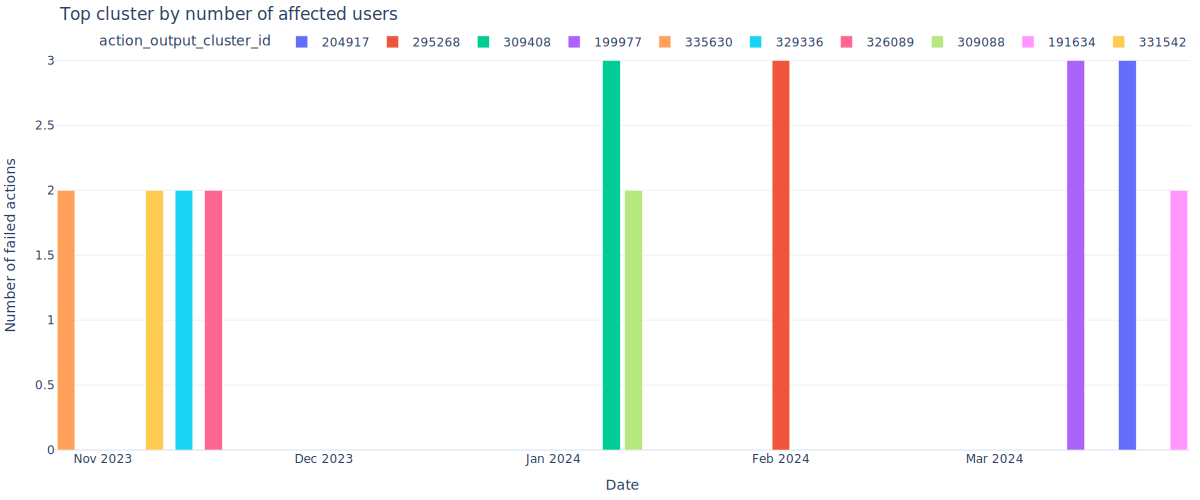

In [431]:
top_clusters_by_unique_users_fig.show()

# Statistics: Top clusters by number of affected users
Outage in external service:

In [373]:
cluster_daily_stats.sort_values("unique_users_num", ascending=False).head(10)

,action_output_date,action_output_cluster_id,unique_users_num,actions_num
23853,2024-03-19 00:00:00+00:00,204917,3,157
7650,2024-01-09 00:00:00+00:00,309408,3,4
23572,2024-03-12 00:00:00+00:00,199977,3,3
9803,2024-02-01 00:00:00+00:00,295268,3,7
24659,2024-03-23 00:00:00+00:00,199341,2,2
24657,2024-03-23 00:00:00+00:00,199331,2,3
39402,2024-04-10 00:00:00+00:00,72963,2,3
5768,2023-12-07 00:00:00+00:00,321665,2,2
9811,2024-02-03 00:00:00+00:00,288051,2,2
14111,2024-02-10 00:00:00+00:00,264321,2,2


In [378]:
print(actions.loc[295268, "action_output_failure"])

error An unexpected error occurred: "https://registry.yarnpkg.com/whatwg-fetch/-/whatwg-fetch-2.0.4.tgz: Request failed \"500 Internal Server Error\"".
info If you think this is a bug, please open a bug report with the information provided in "/home/circleci/project/yarn-error.log".
info Visit https://yarnpkg.com/en/docs/cli/install for documentation about this command.


Lint error in a commonly edited file(s):

In [384]:
print(actions.loc[309408, "action_output_failure"])


  This project uses prettier to format all JavaScript code.
    Please run yarn prettier-all and add changes to files listed below to your commit:


packages/react-test-renderer/src/ReactTestRenderer.js


# Integrations
1. **Incident Management** - widespread errors trigger incident management proc.
2. **Impact Assessment** - alerts have information about the number of affected users.
3. **Remediation Information** - Users can add remediation steps to error clusters.
4. **Error Suppression** - certain widespread errors can be suppressed and the the integration process can be resumed.
5. **Batch Retry** - once the root cause is resolved we can batch retry validation process for a precise set of blocked Code Reviews.
6. **Topline Metrics** - we estimate the impact of specific widespread errors on the topline metrics measuring developer productivity.

# Summary

1. Clustering of near-identical documents eliminates the need of maintaining a long list of normalization rules.
2. Minhash and LSH Forest are efficient solutions for detecting near-identical documents. Proposed settings proposed density of ~2M cluster per 1 GB.
3. For the React case study, during the 1 year period we observed 350k erros. Proposed pipeline produced 300k unique error clusters taking 150MB.
4. Proposed solution scales well and can be deployed in large CI systems.

In [405]:
print("Density:", 2 ** 30 / 256 / 2)
print("Number of errors:", actions.shape[0])
print("Number of clusters:", actions["action_output_cluster_id"].value_counts().shape[0])
print("Space used in MB:", actions["action_output_cluster_id"].value_counts().shape[0] * 256 * 2 / 2 ** 20)

Density: 2097152.0
Number of clusters: 307883
Number of clusters: 341630
Space used in MB: 150.33349609375
